In [86]:
%matplotlib inline

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve,average_precision_score
from sklearn.metrics import mean_squared_error,r2_score
from scipy.sparse import csr_matrix, csc_matrix
import random as random
from sklearn.decomposition import NMF,TruncatedSVD
#Fit the code to the screen
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

### Reading the ratings data

In [87]:
#Reading the ratings data
my_path = !pwd
ratings_filename = "/ml-1m/ratings.dat"
dfratings = pd.read_csv(my_path[0]+ratings_filename, index_col=None, sep='::', header=None)
dfratings.columns = ["userId", "movieId", "rating", "timestamp"]

/tank/home/adif/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.


### Creating ratings sparse matrix

In [88]:
#Split to train and test sets
test_idx = np.array(random.sample(range(0,len(dfratings)), int(len(dfratings)/10)))
train_idx = set(np.arange(len(dfratings))) - set(test_idx)
train_idx = list(train_idx)
dfratings["like"] = dfratings["rating"].apply(lambda x: 1 if x>=4 else 0)
dfratings_test = dfratings.iloc[test_idx]
dfratings_train = dfratings.iloc[train_idx]


### Run SVD and NMF

In [90]:
users = (dfratings_train["userId"]).unique()
movies = (dfratings_train["movieId"]).unique()
users_num = max(users)
movies_num = max(movies)
users_num += 1
movies_num += 1
train_csr = csr_matrix((dfratings_train['like'],(dfratings_train['userId'],dfratings_train['movieId'])), shape=(users_num, movies_num), dtype=float)
RANDOM_SEED=42
predictions_dict = dict()
predictions_dict["Random"] = [random.randint(0,1)  for index,row in dfratings_test.iterrows()]
nmf = NMF(n_components=16) 
us = nmf.fit_transform(train_csr)
vt = nmf.components_
pred = [np.dot(us[row['userId'],:],vt[:,row['movieId']])  for index,row in dfratings_test.iterrows()]
predictions_dict["NMF".format(nmf_components)] = pred
    
svd = TruncatedSVD(n_components=16, random_state=RANDOM_SEED) 
us = svd.fit_transform(train_csr)
vt = svd.components_
pred = [np.dot(us[row['userId'],:],vt[:,row['movieId']])  for index,row in dfratings_test.iterrows()]

predictions_dict["SVD"] = pred



### Plot

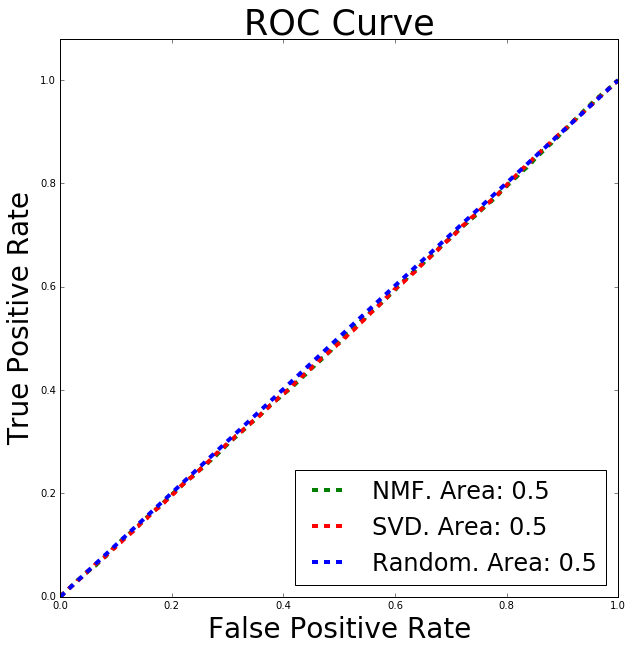

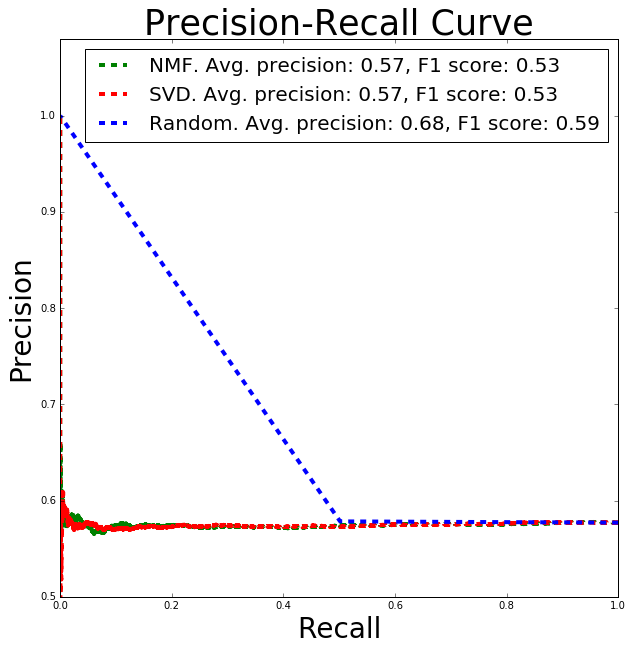

In [91]:
markers = ['+','.']
colors = ["#008000","#ff0000","#0000ff","#000000","#000000","#ff0080","#8000ff","#0080ff","#000080","#00ffff"]

def plot_roc_curve(predictions_dict,label):
    plt.clf()
    fig,ax = plt.subplots()        
    plt.xlabel('False Positive Rate',fontsize=28)
    plt.ylabel('True Positive Rate',fontsize=28)
    ax.set_title("ROC Curve",fontsize=35)
    fig.set_size_inches(10.0, 10.0, forward=True)
    i=0
    for key in predictions_dict.keys():
        pred = predictions_dict[key]
        fpr, tpr, thresholds = roc_curve(label, pred)
        roc_auc = auc(fpr, tpr)
        name = key
        if name.find("SVD")>=0:
            name = "SVD"
        if name.find("NMF")>=0:
            name = "NMF"        
        plt.plot(fpr, tpr,  label= '{0}. Area: {1}'.format(name,round(roc_auc,2)),linestyle='--',linewidth=4,color = colors[i%len(colors)])
        i+=1
        #plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.08])
    plt.legend(loc="lower right",fontsize=24)
    plt.savefig("roc_curve.pdf")
    plt.show()

def plot_precision_recall_curve(predictions_dict,label):
    plt.clf()
    fig,ax = plt.subplots()        
    ax.set_xlabel("Recall",fontsize=28)
    ax.set_ylabel("Precision",fontsize=28)
    ax.set_title("Precision-Recall Curve",fontsize=35)
    fig.set_size_inches(10.0, 10.0, forward=True)
    i=0
    for key in predictions_dict.keys():
        precision, recall, thresholds = precision_recall_curve(label, predictions_dict[key])
        mean_precision = np.mean(precision)
        mean_recall = np.mean(recall)
        f1_score = 2*mean_precision*mean_recall/(mean_precision+mean_recall)
        average_precision = average_precision_score(label, predictions_dict[key])
        name = key
        if name.find("SVD")>=0:
            name = "SVD"
        if name.find("NMF")>=0:
            name = "NMF"            
        plt.plot(recall, precision, label='{0}. Avg. precision: {1}, F1 score: {2}'.format(name,round(average_precision,2),round(f1_score,2)),linestyle='--',linewidth=4,color = colors[i%len(colors)])
        i+=1
    plt.xlim([0.0, 1.0])
    plt.ylim([0.5, 1.08])        
    plt.legend(loc="upper right",fontsize=20)
    plt.savefig("precision_recall_curve.pdf")
    plt.show()
plot_roc_curve(predictions_dict,label)    
plot_precision_recall_curve(predictions_dict,label)